In [56]:
%matplotlib inline
import cv2
import numpy as np
from scipy.spatial import cKDTree
from matplotlib import pyplot as plt
from pyzbar import pyzbar
import re
from PyPDF2 import PdfFileReader, PdfFileWriter
from wand.image import Image
from wand.color import Color
import io
import warnings
from tqdm import tqdm
import math
from skimage.feature import peak_local_max
from crypt import vigenere_decrypt
from itertools import combinations

plt.rcParams["figure.figsize"] = 20, 20

def alpha(color, alpha):
    return (*color[:3], 255 * alpha)

# Colors are usually coded in BGR within openCV

RED = (0, 0, 255, 255)
GREEN = (0, 255, 0, 255)
BLUE = (255, 0, 0, 255)
MAGENTA = (255, 0, 255, 255)
CYAN = (255, 255, 0, 255)
YELLOW = (0, 255, 255, 255)
ORANGE = (0, 102, 255, 255)
GRAY = (127, 127, 127, 255)
WHITE = (255, 255, 255, 255)
BLACK = (0, 0, 0, 255)

In [12]:
def read_pdf(filename, resolution=300):
    with open(filename, 'rb') as f:
        pdf_file = PdfFileReader(f)            
        for i, page in enumerate(pdf_file.pages):
            pdf_bytes = io.BytesIO()
            writer = PdfFileWriter()
            writer.addPage(page)
            writer.write(pdf_bytes)
            pdf_bytes.seek(0)
            with Image(file=pdf_bytes, resolution=resolution) as img:
                img.background_color = Color('white')
                img.alpha_channel = 'remove'
                img_buffer = np.asarray(bytearray(img.make_blob('bmp')), dtype=np.uint8)
                if img_buffer is not None:
                    yield cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)

# this seems to be slower, actually to be tested
def read_pdf_new(filename, resolution=300):
    image_pdf = Image(filename=filename, resolution=resolution)
    image_bmp = image_pdf.convert('bmp')
    for img in image_bmp.sequence:
        img.background_color = Color('white')
        img.alpha_channel = 'remove'
        img_buffer = np.asarray(bytearray(Image(image=img).make_blob('bmp')), dtype=np.uint8)
        yield cv2.imdecode(img_buffer, cv2.IMREAD_UNCHANGED)

In [13]:
def prepare_roi(image, highlight=True, offset=5):
    def decode_bottom_right(data, image_diag):
        m = re.search(r'\((?P<x0>\d+),(?P<y0>\d+)\)-\((?P<x1>\d+),(?P<y1>\d+)\)/\((?P<width>\d+),(?P<height>\d+)\)/(?P<size>\d+(?:\.\d+)?),(?P<page>\d+)(?:,(?P<start>\d+)-(?P<end>\d+))?', data)
        if not m:
            raise RuntimeError("Bottom-right qrcode encoded information do not comply with the expected format:\nfound {}".format(data))
            
        p0, p1 = np.array([m.group('x0'), m.group('y0')], dtype=int), np.array([m.group('x1'), m.group('y1')], dtype=int)
        width = int(m.group('width'))
        height = int(m.group('height'))
        diag = math.sqrt(width * width + height * height)
        size = float(m.group('size')) * image_diag / diag
        
        return { 'p0': p0, 
                 'p1': p1, 
                 'width': width, 
                 'height': height,
                 'size': float(m.group('size')),
                 'page': int(m.group('page')), 
                 'range': (int(m.group('start')), int(m.group('end')))
               }
    def decode_top_left(data):
        m = re.search(r'(?P<id>\d+),(?P<date>\d+/\d+/\d+),\[(?P<sequence>[^\]]+)\]', data)
        if not m:
            raise RuntimeError("Top-left qrcode encoded information do not comply with the expected format:\nfound {}".format(data))
        # check if the correct sequence is encoded or in clear
        if not m.group('sequence'):
            correct = []
        elif ',' in m.group('sequence'):
            correct = m.group('sequence').split(',')
        else:
            correct = vigenere_decrypt(m.group('sequence'), m.group('id')).upper().split(',')
        return { 
            'student_id': m.group('id'),
            'date': m.group('date'),
            'correct': correct
        }
        
    _, binary = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
    qrcodes = pyzbar.decode(binary)
    
    
    assert len(qrcodes) == 2, "Each page should have exactly two qrcodes, found {}".format(len(qrcodes))
    # sort the two qrcodes so that the top-leftmost is the first and the bottom-rightmost is the second
    qrcodes.sort(key=lambda b: b.rect[0])
    
    if highlight:
        for qrcode in qrcodes:
            # extract the bounding box location of the qrcode and draw a green 
            # frame around them
            (x, y, w, h) = qrcode.rect
            # currently assumes that the image has the right orientation 
            # if this is not the case, the qrcode.polygon can be inspected
            # and possibly used for rotation
            cv2.rectangle(image, (x - offset, y - offset), (x + w + offset, y + h + offset), GREEN, 3)
            
    # crop the image just to the qrcodesbarcodes
    tl = np.array(qrcodes[0].rect[:2])
    br = np.array(qrcodes[1].rect[:2]) + np.array(qrcodes[1].rect[2:])
    image = image[tl[1]:br[1], tl[0]:br[0]]        
    
    # extract information from the qrcodes
    metadata = { 
        **decode_top_left(str(qrcodes[0].data)),
        **decode_bottom_right(str(qrcodes[1].data), np.linalg.norm(image.shape[:2])),
    }
    #matrix = cairo.Matrix()
    #matrix.scale(image.shape[1] / metadata['width'], image.shape[0] / metadata['height'])
    #metadata['matrix'] = matrix
    #p0 = np.array(matrix.transform_point(*metadata['p0'])).astype(int)
    #p1 = np.array(matrix.transform_point(*metadata['p1'])).astype(int)
    scaling = np.diag([image.shape[1] / metadata['width'], image.shape[0] / metadata['height']])
    metadata['scaling'] = scaling
    p0 = np.dot(metadata['p0'] - np.array([0, metadata['size']]), scaling).astype(int)
    p1 = np.dot(metadata['p1'], scaling).astype(int)
    roi = image[p0[1]:p1[1], p0[0]:p1[0]]        
    if highlight:
        # draw a frame around the omr area
        cv2.rectangle(image, tuple(p0 - offset), tuple(p1 + offset), BLUE, 3)
    # determine the range of the questions that are present in the current page
    #if metadata['range'][0] is not None and metadata['range'][1] is not None:
    #    metadata['correct'] = metadata['correct'][metadata['range'][0] - 1:metadata['range'][1]]
    #else:
    #    warnings.warn('No answer on page {}'.format(metadata['page']))
    # FIXME: currently fixing a bug in generation, it has to be reset after        
    # metadata['page_correction'] = metadata['correct'][metadata['range'][0] - 1:metadata['range'][1]]
    if metadata['page'] == 1:
        metadata['correct'] = metadata['correct'][:metadata['range'][1] - 1]
    else:
        metadata['correct'] = metadata['correct'][metadata['range'][0] - 2:]
    # the data returned are:
    # - the omr roi
    # - the metadata
    return roi, metadata

In [14]:
def circle_filled_area(binary, c):
    area = 0
    cx, cy = c[:2]
    radius = c[2]
    xbounds = (max(0, int(cx - radius)), min(binary.shape[1], int(cx + radius) + 1))
    w = xbounds[1] - xbounds[0]
    ybounds = (max(0, int(cy - radius)), min(binary.shape[0], int(cy + radius) + 1))
    h = ybounds[1] - ybounds[0]
    enclosing_box = binary[ybounds[0]:ybounds[1], xbounds[0]:xbounds[1]]
    y, x = np.ogrid[-h // 2 : h // 2, -w // 2 : w // 2]
    mask = x * x + y * y > radius * radius
    
    return np.count_nonzero(np.ma.masked_array(enclosing_box, mask).ravel()) 

In [15]:
def detect_circles_edges(roi, metadata, area_threshold=0.45):    
    if metadata['correct'] is None and metadata['range'] is None: # there is no answer on current page
        return []
    # in order to detect the contours in the roi, a blur and an adaptive thresholding is used
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if len(roi.shape) > 2 else roi
    gray = cv2.GaussianBlur(gray, (5, 5), 2)
    binary_for_edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # get the contours
    contours, _ = cv2.findContours(binary_for_edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    # get a more precise binary image for computing area
    _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
    binary += binary_for_edges

    # try to construct the circles
    circles = []
    empty_circles = []
    scaling = metadata['scaling']
    bubble_radius = np.max(np.dot(metadata['size'], scaling) / 2.0)
    # for each detcted contour
    for contour in contours:
        perimeter = cv2.arcLength(contour, True)
        # try to simplify it
        approx = cv2.approxPolyDP(contour, 0.01 * perimeter, True)
        # and check whether it is a candidate to be a circle (in that case append it)
        if len(approx) >= 8:                        
            (cx, cy), radius = cv2.minEnclosingCircle(contour)
            if 0.75 * bubble_radius <= radius <= 1.8 * bubble_radius:
                if circle_filled_area(binary, (int(cx), int(cy), int(radius))) > area_threshold * bubble_radius * bubble_radius * math.pi:
                    circles.append((int(cx), int(cy), int(radius)))
                else:
                    empty_circles.append((int(cx), int(cy), int(radius)))
    # sort circles according to the x component (leftmost first, topmost after)
    return binary, circles, empty_circles

In [16]:
def detect_circles_blob(roi, metadata):
    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if len(roi.shape) > 2 else roi
    gray = cv2.GaussianBlur(gray, (11, 11), 2)
    
    params = cv2.SimpleBlobDetector_Params()
    #matrix = metadata['matrix']
    scaling = metadata['scaling']
    #bubble_radius = min(matrix.transform_distance(metadata['size'], metadata['size'])) / 2.0
    bubble_radius = np.max(np.dot(metadata['size'], scaling) / 2.0)
    params.minDistBetweenBlobs = bubble_radius * 2.0 
    #params.filterByColor = False
    #blobColor = 0 

    # Filter by Area.
    params.filterByArea = True
    params.minArea = bubble_radius * bubble_radius * np.pi * 0.8
    params.maxArea = bubble_radius * bubble_radius * np.pi * 1.8

    # Change thresholds
    params.minThreshold = 160
    params.maxThreshold = 255

    # Filter by Circularity
    #params.filterByCircularity = True
    #params.minCircularity = 0.7

    # Filter by Inertia
    params.filterByInertia = False
    #params.minInertiaRatio = 0.7

    # Filter by Convexity
    params.filterByConvexity = False
    #params.minConvexity = 0.95
    
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(gray)
    circles = list(map(lambda k: (int(k.pt[0]), int(k.pt[1]), int(bubble_radius)), keypoints))
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    binary += cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1]
    
    return binary, circles, []

In [63]:
def detect_circles_laplacian(roi, metadata):
    def round_up_to_odd(f):
        return math.ceil(f) // 2 * 2 + 1 
    
    def collapse_identical_circles(candidates, radius, threshold=0.3):            
        fusion = True
        next_centers = set(candidates)
        while fusion:
            fusion = False
            prev_centers = next_centers
            next_centers = set()
            done = set()
            for c1 in prev_centers:  
                if c1 in done:
                    continue              
                identical = []
                done.add(c1)
                for c2 in prev_centers - done:
                    if np.linalg.norm(np.array(c1[:2]) - np.array(c2[:2])) < threshold * radius:
                        identical.append(c2)                
                if identical:
                    fusion = True
                    for c in identical + [c1]:
                        if c in next_centers:
                            next_centers.remove(c)
                        done.add(c)
                    next_centers.add(tuple(np.mean(identical + [c1], axis=0)))
                else:
                    next_centers.add(c1)
        return next_centers 

    gray = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY) if len(roi.shape) > 2 else roi
    gray = cv2.GaussianBlur(gray, (11, 11), 2)
    
    s = np.max(np.dot(metadata['size'], metadata['scaling']) / 2.0)

    s1 = s / 1.4142 # stretto
    # some denoising
    im1 = cv2.GaussianBlur(gray, (round_up_to_odd(1 + 5 * s1), round_up_to_odd(1 + 5 * s1)), s1)

    s2 = s * 1.4142 #largo
    # some denoising
    im2 = cv2.GaussianBlur(gray, (round_up_to_odd(1 + 5 * s2), round_up_to_odd(1 + 5 * s2)), s2)

    response = im2.astype(float) - im1.astype(float)  #largo - stretto
    response = cv2.normalize(response, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    
    y, x = np.ogrid[-s // 2 : s // 2, -s // 2 : s // 2]
    mask = x * x + y * y <= s * s    
    
    maxima = peak_local_max(response, footprint=mask, #min_distance=s, 
                            exclude_border=False, threshold_rel=0.5, indices=False) * 255
    maxima = cv2.normalize(maxima, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8UC1)
    
    contours, _ = cv2.findContours(maxima, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    candidates = []
    for contour in contours:
        (cx, cy), _ = cv2.minEnclosingCircle(contour)
        candidates.append((cx, cy, s))
    circles = list(map(lambda c: tuple(map(int, c)), collapse_identical_circles(candidates, s)))
        
    binary = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
                                   cv2.THRESH_BINARY_INV, 11, 2)
    binary += cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)[1]    
    
    return binary, circles, []

In [60]:
def process_circles(roi, binary, circles, empty_circles, metadata, offset=5, xdistance=1.25):    
    def circle_intersection_area(c1, c2):
        r1, r2 = c1[2], c2[2]
        d = np.linalg.norm(np.array(c1[:2]) - np.array(c2[:2])) + np.finfo(float).eps
        if r1 < r2: # ensure that r1 >= r2    
            r1, r2 = r2, r1
        if (d > r1 + r2):
            return 0.0        
        if d < r1 - r2: # the circle whose radius is r2 is contained in the circle whose radius is r1
            return maath.pi * r2 * r2
        r1s = r1 * r1
        r2s = r2 * r2
        d1 = (r1s - r2s  + d * d) / (2.0 * d)
        d2 = d - d1
        return r1s * math.acos(d1 / r1) - d1 * math.sqrt(r1s - d1 * d1) + \
               r2s * math.acos(d2 / r2) - d2 * math.sqrt(r2s - d2 * d2)
    
    def highlight_circle(target, c, color, offset=5, **kwargs):
        if "shape" in kwargs and kwargs["shape"] == "rectangle":
            return cv2.rectangle(target, tuple(np.array(c[:2]) - (c[2] + offset)), tuple(np.array(c[:2]) + (c[2] + offset)), color, 3)
        else:
            return cv2.circle(target, c[:2], c[2] + offset, color, 3)
        
    mask = np.ones((*roi.shape[:2], 3), np.uint8) * 255
    # identify the reference_circles first, assuming the leftmost/topmost is the reference one
    circles = sorted(circles)
    pivot = circles[0]
    # the reference circles are those whose center is almost in the same column as the pivot
    reference_circles = [c for c in circles if abs(c[0] - pivot[0]) <= pivot[2]]
    reference_radius = np.max(np.dot(metadata['size'], metadata['scaling']) / 2)
    reference_area = reference_radius * reference_radius * math.pi
    # all the other are the answer circles
    other_circles = [c for c in circles if abs(c[0] - pivot[0]) > pivot[2]]
    # highlight the reference circles
    for c in reference_circles:
        highlight_circle(mask, c, CYAN)
        filled_area = circle_filled_area(binary, c) / reference_area
        text = "{0:.0%}".format(filled_area)
        cv2.putText(mask, text, tuple(np.array(c[:2]) - np.array([c[2], c[2] + 2 * offset])), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.8, CYAN, 3)
    # maintain the information as a mapping between the reference circle and all the
    # answer circles on the same row
    answer_circles = {c: [] for c in reference_circles}
    # process the answer circles
    for c in other_circles:
        # find the closest reference circle, w.r.t. y coordinate
        ydist = np.fromiter((abs(c[1] - rc[1]) for rc in reference_circles), int)
        reference_circle = reference_circles[np.argmin(ydist)]
        answer_circles[reference_circle].append(tuple(list(c) + [True]))
    # and the empty ones (they are meaningful only for edge detection)
    for c in empty_circles:
        # find the closest reference circle, w.r.t. y coordinate
        ydist = np.fromiter((abs(c[1] - rc[1]) for rc in reference_circles), int)
        reference_circle = reference_circles[np.argmin(ydist)]
        answer_circles[reference_circle].append(tuple(list(c) + [False]))
    # now consider each reference circle from the topmost one down
    answer_circles = sorted(answer_circles.items(), key=lambda item: item[0][1])
    # check whether questions and the expected sequence of answers match
    if len(reference_circles) != len(metadata['correct']):
        warnings.warn("Number of questions {} and number of correct answers {} do not match".format(len(reference_circles), len(metadata['correct'])))
    # go through the questions (reference circles) and check the answers
    correction = []    
    for i, ac in enumerate(answer_circles):
        correct_res = set(metadata['correct'][i])
        all_res = set()
        answers_res = set()   
        # now sort again answer circles from the leftmost to the rightmost
        # and check whether there are missing ones (e.g., due to a “wrong” filling)
        # each circle has a distance ratio specified by the xdistance parameter from the
        # previous one
        reference_circle = ac[0]
        given_answers = sorted(ac[1])
        for c in given_answers:
            highlight_circle(mask, c, ORANGE, shape="rectangle")
        # TODO: assumption that the line of answers is almost horizontal, it could be detected
        #       another assumption is that the maximum number of answers is 10
        phantom_circles = []
        for j in range(1, 11):
            # this is a phantom circle that should be present in the image
            c = np.array(reference_circle[:2]) + [j * xdistance * 2 * reference_radius, 0]
            c = tuple(list(c) + [reference_radius]) 
            # check if the phantom circle is outside the roi image or there's nothing below the circle
            if c[0] + c[2] > binary.shape[0] or circle_filled_area(binary, c) < 0.1 * reference_area:
                break
            phantom_circles.append(c)
        
        # let's check if the phantom circles have a detected counterpart
        for a in given_answers:
            distances = np.fromiter((np.linalg.norm(np.array(c[:2]) - np.array(a[:2])) for c in phantom_circles), float)
            closer_phantom_circle = np.argmin(distances)
            if distances[closer_phantom_circle] < reference_radius:
                del phantom_circles[closer_phantom_circle]            
        for c in phantom_circles:
            c = tuple(list(map(int, c)) + [False])
            highlight_circle(mask, c, GRAY)
            given_answers.append(c)                               
        given_answers = sorted(given_answers)
        for j, c in enumerate(given_answers):
            r = chr(j + ord('A'))
            all_res.add(r)
            filled_area = circle_filled_area(binary, c) / reference_area
            text = "{0:.0%}".format(filled_area)
            cv2.putText(mask, text, tuple(np.array(c[:2]) - np.array([c[2], c[2] + 2 * offset])), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, MAGENTA, 3)
            if c[3]:
                answers_res.add(r)
                if r in correct_res:
                    cv2.circle(mask, c[:2], c[2], alpha(GREEN, 1.0), -1)
                else:
                    cv2.circle(mask, c[:2], c[2], alpha(RED, 1.0), -1)
            else:
                if r in correct_res:
                    cv2.circle(mask, c[:2], c[2], alpha(ORANGE, 1.0), -1)
        # check if there are missing answers on the paper-sheet
        missing_answers = correct_res - all_res
        if len(missing_answers) > 0:
            warnings.warn("For question {}, the correct answer{} {} {} not printed on the sheet".format(metadata['correct'][i], "s" if len(missing_answers) > 1 else "", missing_answers, "were" if len(missing_answers) > 1 else "was"))
            ytop = round(reference_circle[1] - 1.3 * reference_circle[2])
            ybottom = round(reference_circle[1] + 1.3 * reference_circle[2])
            cv2.rectangle(mask, (0, ytop), (roi.shape[1], ybottom), RED, 7)
            p = np.array(reference_circle[:2]) + [-reference_circle[2], -reference_circle[2] - 40]
            cv2.putText(mask, "Missing answer(s) {}".format(missing_answers), tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 1, RED, 3)
        # write a text with the given answers and the correct ones close to each reference circle
        p = np.array(reference_circle[0:2]) + [-reference_circle[2], reference_circle[2] + 40]
        tmp = "Detected: " + ("".join(sorted(a for a in answers_res)) if answers_res else "None")
        tmp += "/Correct: " + "".join(sorted(a for a in correct_res))
        cv2.putText(mask, tmp, tuple(p), cv2.FONT_HERSHEY_SIMPLEX, 1, MAGENTA, 3)
        correction.append((answers_res, correct_res))
    return correction, mask

In [61]:
def check_answer_correctness(correction):
    marking = []
    for question in correction:
        correct_rate = len(question[0] & question[1]) / len(question[1])
        wrong_rate = len(question[0] - question[1]) / len(question[1])
        marking.append((2.0 * correct_rate - wrong_rate) / 2.0)
    return marking

In [41]:
filename = "prova_scansione.pdf"
kwargs = { 'only': 1 }    

pdf = read_pdf(filename)
for i, page in enumerate(pdf):
    if 'only' in kwargs and i != kwargs['only'] - 1:
        continue
    roi, metadata = prepare_roi(page)
    binary, circles, empty_circles = detect_circles_edges(roi, metadata)
    assert len(circles) > 0, "No circle has been found"
    correction, mask = process_circles(roi, binary, circles, empty_circles, metadata)
    #print(correction)  
    superimposed = cv2.bitwise_and(mask, roi) #cv2.addWeighted(mask, 0.7, roi, 0.3, 0.0)
    plt.imshow(superimposed)

IndexError: list index out of range

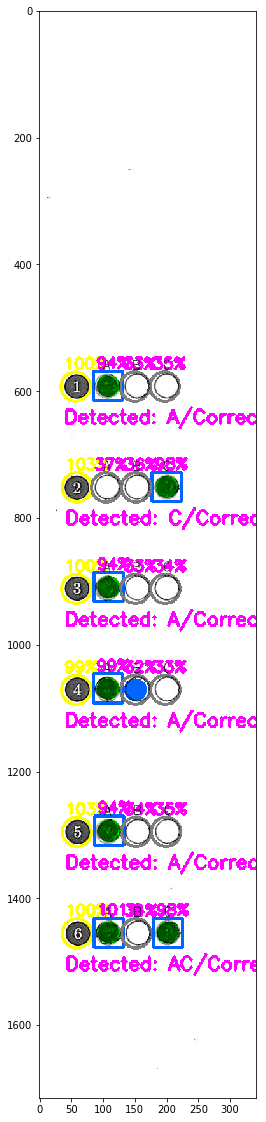

In [64]:
#image = cv2.imread("../prova/145358-2.png")
image = cv2.imread("../prova/143900-1.png")
roi, metadata = prepare_roi(image)
binary, circles, empty_circles = detect_circles_laplacian(roi, metadata)
correction, mask = process_circles(roi, binary, circles, empty_circles, metadata)
superimposed = cv2.bitwise_and(mask, roi)
plt.imshow(superimposed)